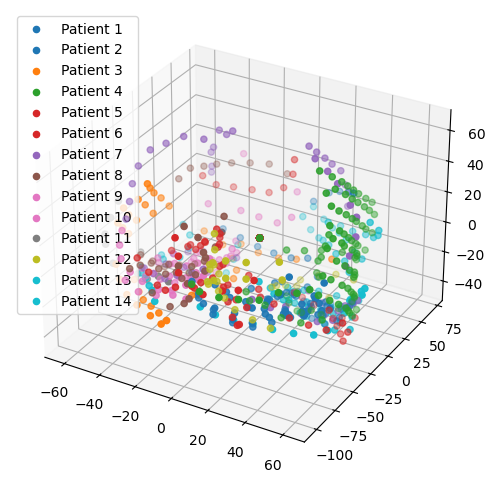

In [71]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D

files = glob.glob("../faces_basic/locs/*.mat")

ecogs_list_loc = []
for file in files:
    ecog = loadmat(file)
    locs = ecog['locs']
    #valid_mask = np.any(locs != 0, axis=1)   # remove zero rows safely
    #clean_locs = locs[valid_mask]
    ecogs_list_loc.append(locs)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Use a colormap to automatically generate distinct colors
colors = plt.cm.tab10(np.linspace(0, 1, len(ecogs_list)))

mapping = []
for i, ecog in enumerate(ecogs_list_loc):
    ax.scatter(
        ecog[:, 0],
        ecog[:, 1],
        ecog[:, 2],
        color=colors[i],
        marker='o',
        label=f'Patient {i+1}'
    )

ax.legend()
plt.show()


In [99]:
#get orders + electrodes in MNI space
from pathlib import Path
import numpy as np
from scipy.io import loadmat

registered_dir = Path("../SuperEeg-M467-project/registered_outputs")
locs_root = Path("../faces_basic/locs")

# Same sorted order as registration code
npy_files = sorted(registered_dir.glob("*_xslocs_registered_mm.npy"))

ecogs_list_loc = []
mapping = []

for i, npy_file in enumerate(npy_files):
    pts = np.load(npy_file)  # already in MNI space
    ecogs_list_loc.append(pts)
    
xyz = np.vstack(ecogs_list_loc)  # 714 x 3, same order as mapping

In [84]:
data_root = Path("../faces_basic/data")

# Same sorted patient order as everything else
patient_ids = [f.name.split("_")[0] for f in npy_files]

ecogs = []
for pid in patient_ids:
    # find the .mat file for this patient
    mat_files = list((data_root / pid).glob("*.mat"))
    if not mat_files:
        print(f"[{pid}] no data .mat found!")
        continue
    ecog = loadmat(str(mat_files[0]))
    ecogs.append(ecog['data'])

In [85]:
#Step one: apply the butternotch filter!
from scipy import signal

sos = signal.butter(4, [59.5, 60.5], btype='bandstop', analog=False, 
                        output='sos', fs=1000)

filtered = []
for file in ecogs:
    filtered.append(signal.sosfiltfilt(sos, file))
    


In [110]:
#Step two: kurtosis
from scipy.stats import kurtosis
cleaned = []
kept_global_indices = []
mapping_clean = []
electrode_offset = 0

for i, file in enumerate(filtered):
    n_electrodes = file.shape[1]
    
    k = kurtosis(file, axis=0)
    good_idx = np.where(k <= 10)[0]
    
    cleaned_file = file[:, good_idx]
    cleaned.append(cleaned_file)
    
    global_good_idx = good_idx + electrode_offset
    kept_global_indices.extend(global_good_idx)
    electrode_offset += n_electrodes
    
    for j in range(len(good_idx)):  # number of KEPT electrodes
        mapping_clean.append([len(mapping_clean), i])  # i = subject index

mapping_clean = np.array(mapping_clean)
kept_global_indices = np.array(kept_global_indices)
xyz_clean = xyz[kept_global_indices]

print(xyz_clean.shape)        # (n_kept_electrodes, 3)
print(mapping_clean.shape)    # (n_kept_electrodes, 2)

(649, 3)
(649, 2)


In [111]:
# drop <2 electrodes, not modified since it didn't change anything
dropped = []
for file in cleaned:
    if file.shape[1] >1:
        dropped.append(file)

In [112]:
#create RBF correlation matrix
# Euclidean distance matrix (714x714)
dist_matrix = cdist(xyz_clean, xyz_clean, metric='euclidean')

# Gaussian RBF kernel: exp(-(epsilon * r)^2)
rbf_matrix = np.exp(-dist_matrix**2 / 20)

correlation_matrices = []
for i, matrix in enumerate(dropped):
    # Get electrode indices for this patient
    patient_electrode_indices = mapping_clean[mapping_clean[:, 1] == i, 0].astype(int)
    
    # Compute pairwise correlation between this patient's electrodes
    corr = pd.DataFrame(matrix).corr()
    # shape: (n_patient_elec x n_patient_elec)

    # RBF weights between ALL 649 electrodes and this patient's electrodes
    # W shape: (714 x n_patient_elec)
    W = rbf_matrix[:, patient_electrode_indices]

    # Equation (6): Cˆ(x,y) = sum_ij W(x,i)*W(y,j)*z(C̄s(i,j))
    #                        / sum_ij W(x,i)*W(y,j)
    # Vectorized: numerator = W @ z_corr @ W.T  →  (714 x 714)
    numerator   = W @ corr @ W.T
    denominator = W @ np.ones_like(corr) @ W.T

    C_hat = np.divide(numerator, denominator, 
                         where=denominator != 0, 
                         out=np.zeros((649, 649)))

    correlation_matrices.append(C_hat)

    

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,1.000000,0.484275,0.445988,0.217690,0.175049,0.108885,0.100432,0.062800,0.122872,0.087086,...,0.111684,0.116512,0.135298,0.218287,0.268063,0.276571,0.279406,0.000941,0.089754,0.082810
1,0.484275,1.000000,0.442571,0.194110,0.186886,0.071520,0.108220,0.079423,0.129066,0.098279,...,0.060929,0.140132,0.097442,0.172395,0.214988,0.235225,0.237000,-0.011696,0.099413,0.118551
2,0.445988,0.442571,1.000000,0.445766,0.221853,0.089370,0.075618,0.110847,0.173638,0.133147,...,0.082779,0.193584,0.042537,0.112443,0.168896,0.233371,0.234182,-0.046357,0.109423,0.171177
3,0.217690,0.194110,0.445766,1.000000,0.254147,0.117608,0.117626,0.200421,0.157675,0.201072,...,0.056252,0.125201,0.010109,0.066218,0.090114,0.126246,0.121454,-0.066662,0.076543,0.123791
4,0.175049,0.186886,0.221853,0.254147,1.000000,0.262052,0.240677,0.237048,0.271040,0.263277,...,0.055403,0.230634,0.106727,0.211049,0.261561,0.272100,0.271940,0.013152,0.187288,0.221665
5,0.108885,0.071520,0.089370,0.117608,0.262052,1.000000,0.441222,0.431634,0.348758,0.361754,...,0.011880,0.196176,0.130496,0.225961,0.246637,0.225034,0.215694,0.043884,0.175723,0.195139
6,0.100432,0.108220,0.075618,0.117626,0.240677,0.441222,1.000000,0.610311,0.366578,0.444033,...,-0.065962,0.239804,0.163321,0.285481,0.323750,0.336289,0.323924,0.073743,0.232767,0.245688
7,0.062800,0.079423,0.110847,0.200421,0.237048,0.431634,0.610311,1.000000,0.401602,0.417515,...,-0.059176,0.233253,0.120912,0.269093,0.299731,0.312959,0.340397,0.068051,0.240951,0.258602
8,0.122872,0.129066,0.173638,0.157675,0.271040,0.348758,0.366578,0.401602,1.000000,0.675048,...,-0.056657,0.173441,0.164155,0.306548,0.315055,0.309358,0.322537,0.104546,0.245771,0.197678
9,0.087086,0.098279,0.133147,0.201072,0.263277,0.361754,0.444033,0.417515,0.675048,1.000000,...,-0.048164,0.063572,0.150222,0.281450,0.273610,0.238343,0.261010,0.051714,0.161812,0.094224


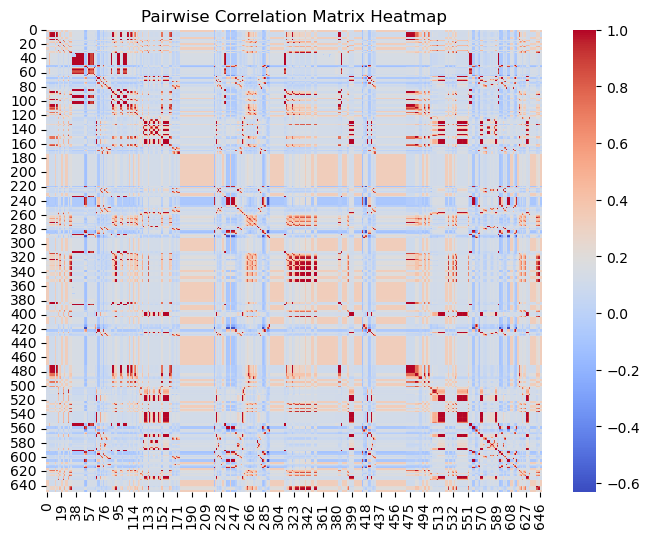

In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Look at one patient

plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrices[6], cmap='coolwarm', fmt=".2f")

plt.title('Pairwise Correlation Matrix Heatmap')
plt.show()